In [1]:
import random
import math
import copy
import time
from collections import namedtuple
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Global Parameters

In [2]:
HyperParams = Dict[str, any]

SEARCH_SPACE = {
    "learning_rate": (1e-4, 1e-1),
    "kernel_size": [3, 5, 7],
    "batch_size": [32, 64, 128],
    "optimizer": ["sgd", "adam", "rmsprop"],
    "n_hidden_layers": [1, 2, 3],
    "neurons": [32, 64, 128, 256],
}

Individual = namedtuple("Individual", ["hp", "fitness"])

# Neural Network Fucntion

In [3]:
def build_model(hp: HyperParams, input_shape=(28, 28, 1), n_classes=10):
    model = models.Sequential()

    k = hp["kernel_size"]
    model.add(
        layers.Conv2D(
            16, (k, k), activation="relu", input_shape=input_shape, padding="same"
        )
    )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())

    # Hidden Layers
    for neurons in hp["neurons"]:
        model.add(layers.Dense(neurons, activation="relu"))
    model.add(layers.Dense(n_classes, activation="softmax"))

    # Optimizer
    lr = hp["learning_rate"]
    opt_name = hp["optimizer"]
    if opt_name == "sgd":
        opt = optimizers.SGD(learning_rate=lr)
    elif opt_name == "adam":
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == "rmsprop":
        opt = optimizers.RMSprop(learning_rate=lr)
    else:
        raise ValueError("Invalid optimizer")
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return model


def evaluate_individual(hp: HyperParams, data, epochs=3, verbose=0) -> float:
    x_train, y_train, x_val, y_val = data

    model = build_model(hp)
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=hp["batch_size"],
        validation_data=(x_val, y_val),
        verbose=verbose,
    )
    val_acc = float(history.history["val_accuracy"][-1])
    tf.keras.backend.clear_session()

    return val_acc

# Genetic Algorithm

## Global Functions

In [4]:
def sample_random_individual() -> HyperParams:
    hp = {}

    lo, hi = SEARCH_SPACE["learning_rate"]
    hp["learning_rate"] = 10 ** random.uniform(math.log10(lo), math.log10(hi))
    hp["kernel_size"] = random.choice(SEARCH_SPACE["kernel_size"])
    hp["batch_size"] = random.choice(SEARCH_SPACE["batch_size"])
    hp["optimizer"] = random.choice(SEARCH_SPACE["optimizer"])
    hp["n_hidden_layers"] = random.choice(SEARCH_SPACE["n_hidden_layers"])
    hp["neurons"] = [
        random.choice(SEARCH_SPACE["neurons"]) for _ in range(hp["n_hidden_layers"])
    ]

    return hp

def mutate(hp: HyperParams, mutation_rate=0.1) -> HyperParams:
    new = copy.deepcopy(hp)

    if random.random() < mutation_rate:
        lo, hi = SEARCH_SPACE["learning_rate"]
        factor = 10 ** random.uniform(-0.5, 0.5)
        new["learning_rate"] = float(np.clip(new["learning_rate"] * factor, lo, hi))
    if random.random() < mutation_rate:
        new["kernel_size"] = random.choice(SEARCH_SPACE["kernel_size"])
    if random.random() < mutation_rate:
        new["batch_size"] = random.choice(SEARCH_SPACE["batch_size"])
    if random.random() < mutation_rate:
        new["optimizer"] = random.choice(SEARCH_SPACE["optimizer"])
    if random.random() < mutation_rate:
        new["n_hidden_layers"] = random.choice(SEARCH_SPACE["n_hidden_layers"])
        new["neurons"] = [
            random.choice(SEARCH_SPACE["neurons"])
            for _ in range(new["n_hidden_layers"])
        ]
    else:
        # Mutate neurons inside existing layers
        for i in range(new["n_hidden_layers"]):
            if random.random() < mutation_rate:
                new["neurons"][i] = random.choice(SEARCH_SPACE["neurons"])
    return new

def single_point_crossover(
    hp1: HyperParams, hp2: HyperParams
) -> Tuple[HyperParams, HyperParams]:
    keys = [
        "learning_rate",
        "kernel_size",
        "batch_size",
        "optimizer",
        "n_hidden_layers",
        "neurons",
    ]
    point = random.randint(1, len(keys) - 1)
    child1 = {}
    child2 = {}
    for i, k in enumerate(keys):
        if i < point:
            child1[k] = copy.deepcopy(hp1[k])
            child2[k] = copy.deepcopy(hp2[k])
        else:
            child1[k] = copy.deepcopy(hp2[k])
            child2[k] = copy.deepcopy(hp1[k])

    for c in (child1, child2):
        if len(c["neurons"]) != c["n_hidden_layers"]:
            if len(c["neurons"]) > c["n_hidden_layers"]:
                c["neurons"] = c["neurons"][: c["n_hidden_layers"]]
            else:
                c["neurons"].extend(
                    [
                        random.choice(SEARCH_SPACE["neurons"])
                        for _ in range(c["n_hidden_layers"] - len(c["neurons"]))
                    ]
                )
    return child1, child2

def roulette_wheel_selection(pop: List[Individual], k=1) -> List[HyperParams]:
    fitnesses = np.array([max(0.0, ind.fitness) for ind in pop])
    total = fitnesses.sum()
    if total <= 0:
        return [copy.deepcopy(random.choice(pop).hp) for _ in range(k)]
    probs = fitnesses / total
    chosen = np.random.choice(len(pop), size=k, p=probs)
    return [copy.deepcopy(pop[i].hp) for i in chosen]

## Standard

In [5]:
def run_standard_ga(data, pop_size=10, generations=5, epochs=3, mutation_rate=0.1):
    pop = [Individual(sample_random_individual(), fitness=0.0) for _ in range(pop_size)]
    history_best = []

    for i in range(len(pop)):
        pop[i] = Individual(
            pop[i].hp, evaluate_individual(pop[i].hp, data, epochs=epochs)
        )
    for gen in range(generations):
        parents = roulette_wheel_selection(pop, k=pop_size)
        offspring = []

        for i in range(0, pop_size, 2):
            p1 = parents[i % pop_size]
            p2 = parents[(i + 1) % pop_size]
            c1_hp, c2_hp = single_point_crossover(p1, p2)
            offspring.append(Individual(mutate(c1_hp, mutation_rate), fitness=0.0))
            if len(offspring) < pop_size:
                offspring.append(Individual(mutate(c2_hp, mutation_rate), fitness=0.0))

        for i in range(len(offspring)):
            offspring[i] = Individual(
                offspring[i].hp,
                evaluate_individual(offspring[i].hp, data, epochs=epochs),
            )

        pop = offspring
        best = max(pop, key=lambda ind: ind.fitness)
        history_best.append(best.fitness)
        print(
            f"[Standard GA] Gen {gen + 1}/{generations} best val_acc = {best.fitness:.4f}"
        )

    return best, history_best

## Latin Hypercube Sampling

In [6]:
def latin_hypercube_sampling(n_samples: int) -> List[HyperParams]:
    rng = np.random.default_rng()
    lr_lo, lr_hi = SEARCH_SPACE["learning_rate"]
    cut = np.linspace(0, 1, n_samples + 1)
    u = rng.uniform(size=n_samples)

    samples = []
    for i in range(n_samples):
        frac = cut[i] + u[i] * (cut[i + 1] - cut[i])
        lr = 10 ** (math.log10(lr_lo) + frac * (math.log10(lr_hi) - math.log10(lr_lo)))
        kernel = SEARCH_SPACE["kernel_size"][i % len(SEARCH_SPACE["kernel_size"])]
        batch = SEARCH_SPACE["batch_size"][(i + 1) % len(SEARCH_SPACE["batch_size"])]
        opt = SEARCH_SPACE["optimizer"][(i + 2) % len(SEARCH_SPACE["optimizer"])]
        n_hidden = SEARCH_SPACE["n_hidden_layers"][
            i % len(SEARCH_SPACE["n_hidden_layers"])
        ]
        neurons = [
            SEARCH_SPACE["neurons"][(i + j) % len(SEARCH_SPACE["neurons"])]
            for j in range(n_hidden)
        ]

        samples.append(
            {
                "learning_rate": lr,
                "kernel_size": kernel,
                "batch_size": batch,
                "optimizer": opt,
                "n_hidden_layers": n_hidden,
                "neurons": neurons,
            }
        )
    random.shuffle(samples)

    return samples

In [7]:
def run_lhs_ga(data, pop_size=10, generations=5, epochs=3, mutation_rate=0.1):
    initial_hps = latin_hypercube_sampling(pop_size)
    pop = [Individual(hp, fitness=0.0) for hp in initial_hps]

    for i in range(len(pop)):
        pop[i] = Individual(
            pop[i].hp, evaluate_individual(pop[i].hp, data, epochs=epochs)
        )
    history_best = []
    for gen in range(generations):
        parents = roulette_wheel_selection(pop, k=pop_size)
        offspring = []
        for i in range(0, pop_size, 2):
            p1 = parents[i % pop_size]
            p2 = parents[(i + 1) % pop_size]
            c1_hp, c2_hp = single_point_crossover(p1, p2)
            offspring.append(Individual(mutate(c1_hp, mutation_rate), fitness=0.0))
            if len(offspring) < pop_size:
                offspring.append(Individual(mutate(c2_hp, mutation_rate), fitness=0.0))
        for i in range(len(offspring)):
            offspring[i] = Individual(
                offspring[i].hp,
                evaluate_individual(offspring[i].hp, data, epochs=epochs),
            )
        pop = offspring
        best = max(pop, key=lambda ind: ind.fitness)
        history_best.append(best.fitness)
        print(f"[LHS GA] Gen {gen + 1}/{generations} best val_acc = {best.fitness:.4f}")

    return best, history_best

## Stochastic Universal Selection

In [8]:
def stochastic_universal_sampling(pop: List[Individual], k=1) -> List[HyperParams]:
    fitnesses = np.array([max(0.0, ind.fitness) for ind in pop])
    total = fitnesses.sum()
    if total <= 0:
        return [copy.deepcopy(random.choice(pop).hp) for _ in range(k)]
    pointers = []
    start = random.random() * (total / k)
    step = total / k
    pointers = [start + i * step for i in range(k)]
    selected = []
    cum = 0.0
    idx = 0
    for p in pointers:
        while cum + fitnesses[idx] < p:
            cum += fitnesses[idx]
            idx += 1
            if idx >= len(pop):
                idx = len(pop) - 1
                break
        selected.append(copy.deepcopy(pop[idx].hp))

    return selected

In [9]:
def run_sus_ga(data, pop_size=10, generations=5, epochs=3, mutation_rate=0.1):
    pop = [Individual(sample_random_individual(), fitness=0.0) for _ in range(pop_size)]
    for i in range(len(pop)):
        pop[i] = Individual(
            pop[i].hp, evaluate_individual(pop[i].hp, data, epochs=epochs)
        )
    history_best = []
    for gen in range(generations):
        parents = stochastic_universal_sampling(pop, k=pop_size)
        offspring = []
        for i in range(0, pop_size, 2):
            p1 = parents[i % pop_size]
            p2 = parents[(i + 1) % pop_size]
            c1_hp, c2_hp = single_point_crossover(p1, p2)
            offspring.append(Individual(mutate(c1_hp, mutation_rate), fitness=0.0))
            if len(offspring) < pop_size:
                offspring.append(Individual(mutate(c2_hp, mutation_rate), fitness=0.0))
        for i in range(len(offspring)):
            offspring[i] = Individual(
                offspring[i].hp,
                evaluate_individual(offspring[i].hp, data, epochs=epochs),
            )
        pop = offspring
        best = max(pop, key=lambda ind: ind.fitness)
        history_best.append(best.fitness)
        print(f"[SUS GA] Gen {gen + 1}/{generations} best val_acc = {best.fitness:.4f}")
    return best, history_best

## Uniform Crossover

In [10]:
def uniform_crossover(hp1: HyperParams, hp2: HyperParams, swap_prob=0.5):
    child = {}
    for key in hp1.keys():
        if random.random() < swap_prob:
            child[key] = copy.deepcopy(hp1[key])
        else:
            child[key] = copy.deepcopy(hp2[key])

    if len(child["neurons"]) != child["n_hidden_layers"]:
        if len(child["neurons"]) > child["n_hidden_layers"]:
            child["neurons"] = child["neurons"][: child["n_hidden_layers"]]
        else:
            child["neurons"].extend(
                [
                    random.choice(SEARCH_SPACE["neurons"])
                    for _ in range(child["n_hidden_layers"] - len(child["neurons"]))
                ]
            )
    return child

In [11]:
def run_uniform_crossover_ga(
    data, pop_size=10, generations=5, epochs=3, mutation_rate=0.1
):
    pop = [Individual(sample_random_individual(), fitness=0.0) for _ in range(pop_size)]

    for i in range(len(pop)):
        pop[i] = Individual(
            pop[i].hp, evaluate_individual(pop[i].hp, data, epochs=epochs)
        )

    history_best = []
    for gen in range(generations):
        parents = roulette_wheel_selection(pop, k=pop_size)
        offspring = []
        for i in range(0, pop_size, 2):
            p1 = parents[i % pop_size]
            p2 = parents[(i + 1) % pop_size]
            c1_hp = uniform_crossover(p1, p2, swap_prob=0.5)
            c2_hp = uniform_crossover(p2, p1, swap_prob=0.5)
            offspring.append(Individual(mutate(c1_hp, mutation_rate), fitness=0.0))
            if len(offspring) < pop_size:
                offspring.append(Individual(mutate(c2_hp, mutation_rate), fitness=0.0))

        for i in range(len(offspring)):
            offspring[i] = Individual(
                offspring[i].hp,
                evaluate_individual(offspring[i].hp, data, epochs=epochs),
            )
        pop = offspring
        best = max(pop, key=lambda ind: ind.fitness)
        history_best.append(best.fitness)
        print(
            f"[Uniform Crossover GA] Gen {gen + 1}/{generations} best val_acc = {best.fitness:.4f}"
        )

    return best, history_best

# Adaptive Mutation

In [12]:
def run_adaptive_mutation_ga(
    data, pop_size=10, generations=5, epochs=3, base_mutation=0.1
):
    pop = [Individual(sample_random_individual(), fitness=0.0) for _ in range(pop_size)]
    for i in range(len(pop)):
        pop[i] = Individual(
            pop[i].hp, evaluate_individual(pop[i].hp, data, epochs=epochs)
        )
    history_best = []
    mutation_rate = base_mutation
    best_so_far = max(pop, key=lambda ind: ind.fitness)
    stagnation = 0
    for gen in range(generations):
        parents = roulette_wheel_selection(pop, k=pop_size)
        offspring = []
        for i in range(0, pop_size, 2):
            p1 = parents[i % pop_size]
            p2 = parents[(i + 1) % pop_size]
            c1_hp, c2_hp = single_point_crossover(p1, p2)
            offspring.append(Individual(mutate(c1_hp, mutation_rate), fitness=0.0))
            if len(offspring) < pop_size:
                offspring.append(Individual(mutate(c2_hp, mutation_rate), fitness=0.0))
        for i in range(len(offspring)):
            offspring[i] = Individual(
                offspring[i].hp,
                evaluate_individual(offspring[i].hp, data, epochs=epochs),
            )
        pop = offspring
        current_best = max(pop, key=lambda ind: ind.fitness)
        history_best.append(current_best.fitness)
        
        # adapt mutation
        if current_best.fitness <= best_so_far.fitness + 1e-6:
            stagnation += 1
            mutation_rate = min(0.5, base_mutation * (1 + stagnation * 0.5))  # increase
        else:
            stagnation = 0
            mutation_rate = max(0.01, base_mutation * 0.5)  # reduce
            best_so_far = current_best
        print(
            f"[Adaptive Mut GA] Gen {gen + 1}/{generations} best val_acc = {current_best.fitness:.4f} mutation_rate={mutation_rate:.3f}"
        )
    return best_so_far, history_best

## Steady-State

In [13]:
def tournament_selection(pop: List[Individual], k=1, tourn_size=3):
    selected = []
    for _ in range(k):
        contenders = random.sample(pop, min(tourn_size, len(pop)))
        winner = max(contenders, key=lambda ind: ind.fitness)
        selected.append(copy.deepcopy(winner.hp))

    return selected

In [14]:
def run_steady_state_ga(
    data, pop_size=10, generations=20, epochs=3, mutation_rate=0.1, replace_k=2
):
    pop = [Individual(sample_random_individual(), fitness=0.0) for _ in range(pop_size)]
    for i in range(len(pop)):
        pop[i] = Individual(
            pop[i].hp, evaluate_individual(pop[i].hp, data, epochs=epochs)
        )

    history_best = []
    for gen in range(generations):
        parents = tournament_selection(pop, k=replace_k * 2, tourn_size=3)

        offspring = []
        for i in range(0, len(parents), 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % len(parents)]
            c1_hp, c2_hp = single_point_crossover(p1, p2)
            offspring.append(Individual(mutate(c1_hp, mutation_rate), fitness=0.0))
            if len(offspring) < replace_k:
                offspring.append(Individual(mutate(c2_hp, mutation_rate), fitness=0.0))

        for i in range(len(offspring)):
            offspring[i] = Individual(
                offspring[i].hp,
                evaluate_individual(offspring[i].hp, data, epochs=epochs),
            )

        pop_sorted = sorted(pop, key=lambda ind: ind.fitness)
        for i in range(len(offspring)):
            pop_sorted[i] = offspring[i]

        pop = pop_sorted
        best = max(pop, key=lambda ind: ind.fitness)
        history_best.append(best.fitness)
        print(
            f"[Steady-State GA] Gen {gen + 1}/{generations} best val_acc = {best.fitness:.4f}"
        )

    return best, history_best

# Data Preparation

In [15]:
def prepare_data(data_fraction=1.0, val_fraction=0.2):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x = np.concatenate([x_train, x_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)

    x = x.astype("float32") / 255.0
    x = np.expand_dims(x, -1)
    y = to_categorical(y, 10)

    idx = np.arange(len(x))
    np.random.shuffle(idx)

    x = x[idx]
    y = y[idx]

    # subset
    if data_fraction < 1.0:
        n = int(len(x) * data_fraction)
        x = x[:n]
        y = y[:n]

    n_val = int(len(x) * val_fraction)
    x_val = x[:n_val]
    y_val = y[:n_val]
    x_train = x[n_val:]
    y_train = y[n_val:]

    return (x_train, y_train, x_val, y_val)

# Main RUN

In [16]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

POP_SIZE = 8
GENERATIONS = 1

EPOCHS = 1  # Model epochs
DATA_FRACTION = 0.1  # MNIST data Fraction

data = prepare_data(data_fraction=DATA_FRACTION)

results = {}
histories = {}

start_all = time.time()

print("\n=== Standard GA ===")
best_std, hist_std = run_standard_ga(
    data,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    epochs=EPOCHS,
    mutation_rate=0.12,
)
results["Standard"] = best_std
histories["Standard"] = hist_std


print("\n=== LHS GA ===")
best_lhs, hist_lhs = run_lhs_ga(
    data,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    epochs=EPOCHS,
    mutation_rate=0.12,
)
results["LHS"] = best_lhs
histories["LHS"] = hist_lhs

print("\n=== Running SUS GA ===")
best_sus, hist_sus = run_sus_ga(
    data,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    epochs=EPOCHS,
    mutation_rate=0.12,
)
results["SUS"] = best_sus
histories["SUS"] = hist_sus

print("\n=== Uniform Crossover GA ===")
best_uni, hist_uni = run_uniform_crossover_ga(
    data,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    epochs=EPOCHS,
    mutation_rate=0.12,
)
results["UniformCrossover"] = best_uni
histories["UniformCrossover"] = hist_uni

print("\n=== Adaptive Mutation GA ===")
best_adapt, hist_adapt = run_adaptive_mutation_ga(
    data,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    epochs=EPOCHS,
    base_mutation=0.12,
)
results["AdaptiveMutation"] = best_adapt
histories["AdaptiveMutation"] = hist_adapt

print("\n=== Steady-State GA ===")
best_ss, hist_ss = run_steady_state_ga(
    data,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    epochs=EPOCHS,
    mutation_rate=0.12,
    replace_k=2,
)
results["SteadyState"] = best_ss
histories["SteadyState"] = hist_ss

total_time = time.time() - start_all
print(f"\nAll runs took {total_time:.1f} seconds.")


=== Standard GA ===


/Users/mateusrico/Genetic Network/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[Standard GA] Gen 1/1 best val_acc = 0.9243

=== LHS GA ===
[LHS GA] Gen 1/1 best val_acc = 0.9150

=== Running SUS GA ===
[SUS GA] Gen 1/1 best val_acc = 0.9443

=== Uniform Crossover GA ===
[Uniform Crossover GA] Gen 1/1 best val_acc = 0.9507

=== Adaptive Mutation GA ===
[Adaptive Mut GA] Gen 1/1 best val_acc = 0.9479 mutation_rate=0.060

=== Steady-State GA ===
[Steady-State GA] Gen 1/1 best val_acc = 0.9071

All runs took 87.8 seconds.


# Results

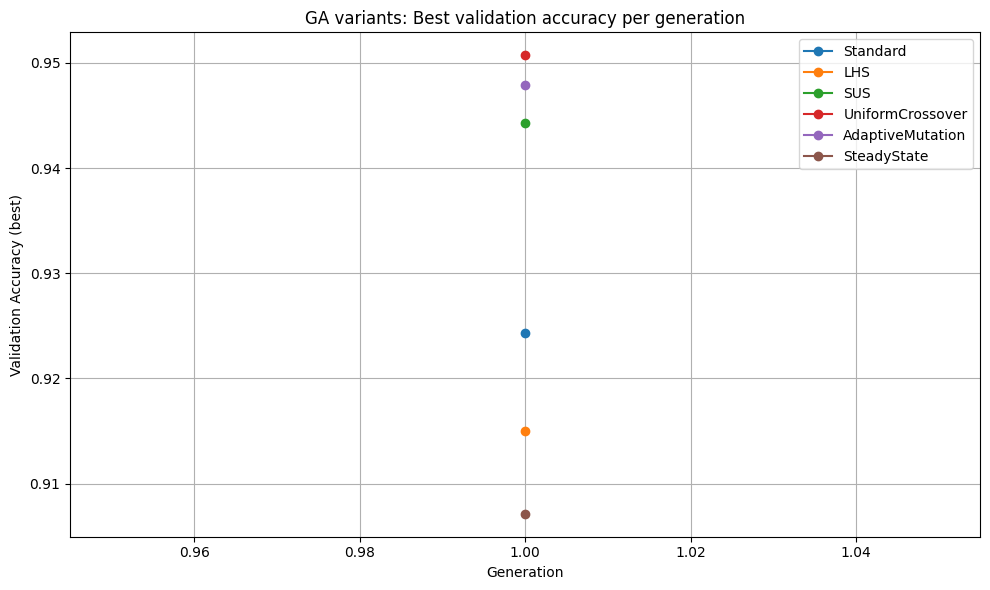

In [17]:
plt.figure(figsize=(10, 6))
for name, hist in histories.items():
    plt.plot(range(1, len(hist) + 1), hist, marker="o", label=name)
plt.xlabel("Generation")
plt.ylabel("Validation Accuracy (best)")
plt.title("GA variants: Best validation accuracy per generation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ga_variants_gen_progress.png")

plt.show()

In [18]:
for name, ind in results.items():
    print(f"\n--- {name} ---")
    print(f"Val Accuracy: {ind.fitness:.4f}")
    print("Hyperparameters:")
    for k, v in ind.hp.items():
        print(f"  {k}: {v}")


--- Standard ---
Val Accuracy: 0.9243
Hyperparameters:
  learning_rate: 0.008284768840933803
  kernel_size: 3
  batch_size: 128
  optimizer: adam
  n_hidden_layers: 1
  neurons: [128]

--- LHS ---
Val Accuracy: 0.9150
Hyperparameters:
  learning_rate: 0.001253131445702573
  kernel_size: 7
  batch_size: 32
  optimizer: adam
  n_hidden_layers: 3
  neurons: [64, 128, 256]

--- SUS ---
Val Accuracy: 0.9443
Hyperparameters:
  learning_rate: 0.007995642024248066
  kernel_size: 7
  batch_size: 32
  optimizer: adam
  n_hidden_layers: 2
  neurons: [32, 32]

--- UniformCrossover ---
Val Accuracy: 0.9507
Hyperparameters:
  learning_rate: 0.009293387228853733
  kernel_size: 7
  batch_size: 32
  optimizer: adam
  n_hidden_layers: 1
  neurons: [64]

--- AdaptiveMutation ---
Val Accuracy: 0.9479
Hyperparameters:
  learning_rate: 0.0018902160135938783
  kernel_size: 7
  batch_size: 32
  optimizer: adam
  n_hidden_layers: 1
  neurons: [128]

--- SteadyState ---
Val Accuracy: 0.9071
Hyperparameters:
  